In [1]:
import numpy as np

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.providers import Backend

simulator_backend = Aer.get_backend("aer_simulator")

In [2]:
class QnnCircuit:
  def __init__(self, n_qubits: int, n_layers: int) -> None:
    self.n_qubits = n_qubits
    self.n_layers = n_layers
    self._circuit = QuantumCircuit(n_qubits, n_qubits)
    self._input = np.zeros(n_qubits)
    self._params = np.zeros((n_layers, n_qubits, 3))

    self._transpiled_circuit = None
    self._backend = None
    self._count = None

  def set_input(self, input: np.ndarray) -> None:
    assert input.shape == self._input.shape
    self._input = input
  
  def set_params(self, params: np.ndarray) -> None:
    assert params.shape == self._params.shape
    self._params = params

  def build(self, backend: Backend) -> None:
    self._circuit.clear()
    self._add_embed_layer()
    self._add_pqc_layer()
    self._add_measure()
    self._transpiled_circuit = transpile(self._circuit, backend)
    self._backend = backend

  def run(self, shots=1000):
    assert self._transpiled_circuit is not None
    result = self._backend.run(self._transpiled_circuit, shots)
    return result.result().get_counts()

  def _add_embed_layer(self) -> None:
    for i, theta in enumerate(self._input):
      self._circuit.ry(theta, i)
    self._circuit.barrier()
    
  def _add_pqc_layer(self) -> None:
    for param in self._params:
      for i, theta in enumerate(param):
        self._circuit.u(*theta, i)
      for i in range(self.n_qubits - 1):
        self._circuit.cz(i, i + 1)
    self._circuit.barrier()
  
  def _add_measure(self) -> None:
    self._circuit.measure(
      list(range(self.n_qubits)), 
      list(range(self.n_qubits))
    )

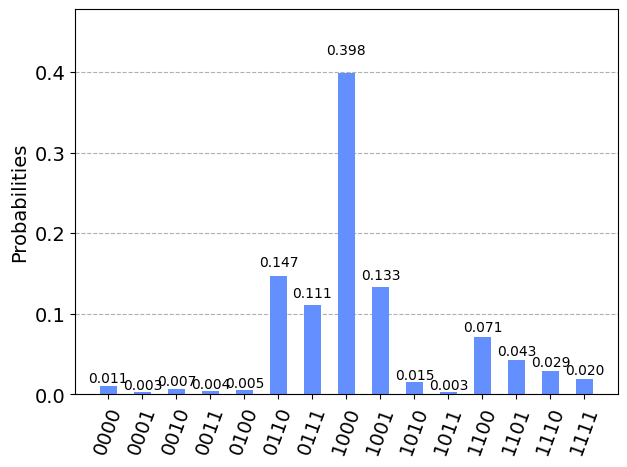

In [3]:
param_1 = np.array([1, 2, 3, 4])
param_2 = np.array([[1, 2, 3], [3, 2, 1], [5, 4, 6], [2, 6, 4]])
param_3 = np.array([param_2, param_2, param_2])

qc = QnnCircuit(4, 3)
qc.set_input(param_1)
qc.set_params(param_3)
qc.build(simulator_backend)
cnt = qc.run()

plot_histogram(cnt)

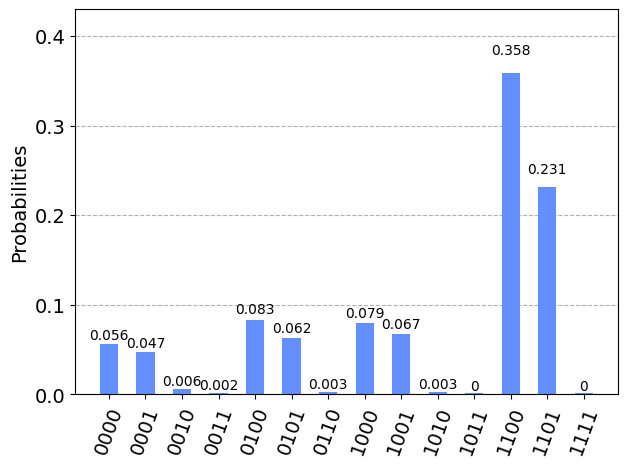

In [4]:
param_1 = np.array([7, 3, 8, 1])
param_2 = np.array([[1, 2, 3], [3, 2, 1], [5, 4, 6], [2, 6, 4]])
param_3 = np.array([param_2, param_2, param_2])

qc.set_input(param_1)
qc.set_params(param_3)
qc.build(simulator_backend)
cnt = qc.run()

plot_histogram(cnt)